This notebook uses iFeatureOmega, a feature generation software, to add to our feature space for a RandomForestClassifier that predicts protein pair functionality.

To do:

1) Write unit tests for iFeatureOmega
2) time trial for different descriptors - DONE
3) Figure out how to append meso and thermo descriptors
4) Make sure protein length is in training
5) try changing subject_align_len to subject_align_len/m_protein_len
6) log(ratio) for proteins approacing zero or infinity
    take distributions to assess for this.

To do:

1) Write unit tests for iFeatureOmega
2) time trial for different descriptors - DONE
3) Figure out how to append meso and thermo descriptors

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.feature_selection
import unittest
import iFeatureOmegaCLI
import Bio.SeqIO
import Bio.SeqRecord
import io
from io import StringIO
import time

In [2]:
cd /Users/loganroberts/Learn2Therm/ValidProt/FAFSA

/Users/loganroberts/Learn2Therm/ValidProt/FAFSA


In [3]:
#convert to pandas df
df = pd.read_csv('learn2therm_sample_50k.csv')
df.columns

Index(['Unnamed: 0', 'local_gap_compressed_percent_id',
       'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id',
       'query_align_len', 'query_align_cov', 'subject_align_len',
       'subject_align_cov', 'bit_score', 'thermo_index', 'meso_index',
       'prot_pair_index', 'meso_protein_int_index', 'thermo_protein_int_index',
       'taxa_pair_index', 'local_gap_compressed_percent_id_16s',
       'scaled_local_query_percent_id_16s',
       'scaled_local_symmetric_percent_id_16s', 'query_align_cov_16s',
       'subject_align_cov_16s', 'bit_score_16s', 'm_ogt', 't_ogt',
       'ogt_difference', 'm_protein_seq', 't_protein_seq', 'm_protein_desc',
       't_protein_desc', 'm_protein_len', 't_protein_len'],
      dtype='object')

In [4]:
cd /Users/loganroberts/Learn2Therm/ValidProt/notebooks

/Users/loganroberts/Learn2Therm/ValidProt/notebooks


In [7]:
target = pd.read_csv('protein_match_50k')

In [8]:
target

,Unnamed: 0,prot_pair_index,protein_match,Jaccard_Score
0,0,48641291,Yes,1.00
1,1,92992745,Yes,1.00
2,2,157628663,Yes,1.00
3,3,136708305,Yes,1.00
4,4,133672542,Yes,1.00
...,...,...,...,...
48845,4875,78849058,No,0.25
48846,4876,108797464,Yes,1.00
48847,4877,161110219,No,0.25
48848,4878,74177185,Yes,0.50


In [9]:
df = pd.merge(df, target, on=['prot_pair_index'])
df.shape

(48850, 33)

In [10]:
df

,Unnamed: 0_x,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len,Unnamed: 0_y,protein_match,Jaccard_Score
0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202,0,Yes,1.00
1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237,1,Yes,1.00
2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252,2,Yes,1.00
3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269,3,Yes,1.00
4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66,4,Yes,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48845,49995,0.344828,0.169972,0.192308,180,0.509915,200,0.738007,53,14963,...,24.5,MDNATFRLGDDLSVRLPGHSRWIGQVEREQRWLPWLAPRLPLTVST...,MPPQPRPLRPNDPREIGGFALLGRLGEGGQGTVYLGGAPDGRRVAV...,aminoglycoside phosphotransferase family protein,serine/threonine protein kinase,271,353,4875,No,0.25
48846,49996,0.417989,0.389163,0.392060,190,0.935961,187,0.935000,314,7134,...,26.0,MFRTGVKAEIGRSLAVVGEAEDVERAVRVVLEQRPDVVLLDVHLPG...,MILEAEPDIVVVGEAGDGEKAVEEARALQPDVVLMDIRMPRKDGVE...,response regulator transcription factor,response regulator transcription factor,200,203,4876,Yes,1.00
48847,49997,0.352174,0.239645,0.242152,230,0.680473,227,0.685801,279,7134,...,24.5,MIRLAELTKTYPGQQHPAVDGISMEVAEGEIVVLVGPSGCGKTTTL...,MTEQPILSARGLTVDFRLRGGRRARAVDGVDLDLAPGEVLALAGES...,ABC transporter ATP-binding protein,ABC transporter ATP-binding protein,331,338,4877,No,0.25
48848,49998,0.334764,0.331915,0.329810,232,0.987234,230,0.966387,281,11324,...,25.0,MSESHAGALLSVRGLTAGYGGATALDGVSLTVAAGETVALLGANGA...,MSLLTTSGLTRHFSGIHAVEGVDFTLEAGEIRALIGSNGAGKTTLV...,ABC transporter ATP-binding protein,ABC transporter ATP-binding protein,238,235,4878,Yes,0.50


In [18]:
get_fasta_from_dataframe(df, 'AAC_descriptors.fasta')

NameError: name 'get_fasta_from_dataframe' is not defined

In [17]:
protein = iFeatureOmegaCLI.iProtein('AAC_descriptors.fasta')

#not sure why we need this yet. Right now it is stored in local directory.
params = protein.import_parameters('protein_parameters.json')

protein.get_descriptor('AAC')

print(protein.encodings)

File imported successfully.
Empty DataFrame
Columns: [AAC_A, AAC_C, AAC_D, AAC_E, AAC_F, AAC_G, AAC_H, AAC_I, AAC_K, AAC_L, AAC_M, AAC_N, AAC_P, AAC_Q, AAC_R, AAC_S, AAC_T, AAC_V, AAC_W, AAC_Y]
Index: []


In [11]:
protein.to_csv('AAC.csv', index=False, header=False)

True

In [12]:
encodings = pd.read_csv('AAC.csv', header=None, index_col=None)
type(encodings)

pandas.core.frame.DataFrame

Try PCA analysis on Amino Acid Composition:

In [13]:
data = iFeatureOmegaCLI.iAnalysis(encodings)
data.PCA(n_components=2)
data.dimension_to_csv('PCA_result.csv')

In [14]:
AA_comp = pd.read_csv('PCA_result.csv', sep=',', header=None, index_col=None)

In [15]:
MyPlot = iFeatureOmegaCLI.iPlot(AA_comp, label=True)
type(MyPlot)

iFeatureOmegaCLI.iFeatureOmegaCLI.iPlot

In [16]:
len(AA_comp)

6348

In [17]:
vector = encodings.values.flatten()

In [18]:
vector

array([0.14563107, 0.00970874, 0.07281553, ..., 0.10756972, 0.        ,
       0.00398406])

In [19]:
%matplotlib inline

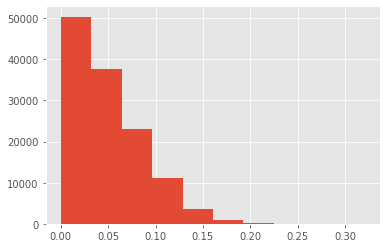

In [20]:
import matplotlib.pyplot as plt

# Plot a histogram of the array
plt.hist(vector)

# Show the plot
plt.show()


In [21]:
#make a function for above

def plot_dists(dataframe):
    
    get_fasta_from_dataframe(df, 'descriptors.fasta')
    
    protein = iFeatureOmegaCLI.iProtein('descriptors.fasta')

    #not sure why we need this yet. Right now it is stored in local directory.
    params = protein.import_parameters('protein_parameters.json')
    
    protein_descriptors = ['AAC', 'GAAC', 'DistancePair','CTDC', 'CTDT', 'CTDD', 'CTriad',
                'CKSAAGP type 1', 'PseKRAAC type 1', 'PseKRAAC type 2',
                'PseKRAAC type 3B',
                'APAAC', 'QSOrder']
    
    for descriptor in protein_descriptors:
        
        protein.get_descriptor(descriptor)
        
        protein.to_csv(f'{descriptor}.csv', index=False, header=False)
        
        encodings = pd.read_csv(f'{descriptor}.csv', header=None, index_col=None)
        
        vector = encodings.values.flatten()
        
        plt.hist(vector)
        plt.xlabel(descriptor)

        # Show the plot
        plt.show()
        

In [22]:
df

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len,Jaccard_Score,protein_match
0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,50.0,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202,1.0,Yes
1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,54.0,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237,1.0,Yes
2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,50.0,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252,1.0,Yes
3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,50.0,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269,1.0,Yes
4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,50.0,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66,1.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,6495,0.387574,0.367978,0.360882,336,0.943820,337,0.910811,588,11707,...,50.0,20.0,MDNEKPIVDFSALRDELGKNYEPVQVMDGQAKVIKPEIVSKYSNDQ...,MKLEFPILQIVDENGNLVNENYRKAITEELVKKFYYHMIRIRTFDR...,pyruvate dehydrogenase (acetyl-transferring) E...,pyruvate dehydrogenase (acetyl-transferring) E...,370,356,0.5,Yes
6344,6496,0.488462,0.488462,0.455197,258,0.992308,263,0.882550,619,875,...,50.0,20.0,MANPYLDDLRLAHVLADSADNLSMDRFGALDLEVSTKPDMTYVTES...,MTRPYADDIHLAKRLADTADAITVPRYSVRDLTVRTKPDRSPVTDA...,histidinol phosphatase,histidinol-phosphatase,298,260,1.0,Yes
6345,6497,0.383838,0.376238,0.374384,296,0.976898,299,0.977124,436,5381,...,45.0,21.5,MGHDHDHSHGTATTNRTKLAWAFGITFTILIAEVIGAILTNSLALL...,MAHQHGPARPEHASGRYLKRLMAAFGIGLVFMVLEVVVGVLTGSLA...,cation diffusion facilitator family transporter,cation diffusion facilitator family transporter,306,303,1.0,Yes
6346,6498,0.769231,0.769231,0.769231,78,1.000000,78,1.000000,258,14963,...,52.5,22.5,MAKPALRKPKKKSNPLKAAKISYVDYKDTALLRKFISDRGKIRARR...,MAKQPPRKPKKKVCVFCQEKISYVDYKDTALLRKFISDRGKIRARR...,30S ribosomal protein S18,30S ribosomal protein S18,78,78,1.0,Yes


File imported successfully.


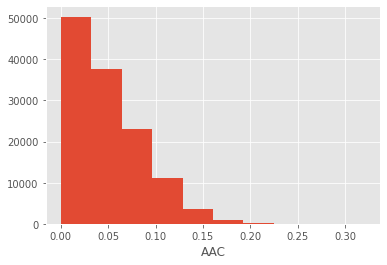

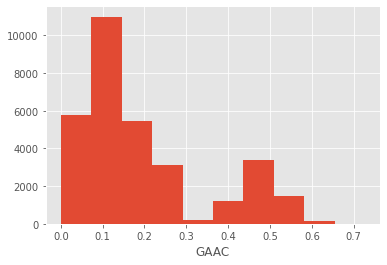

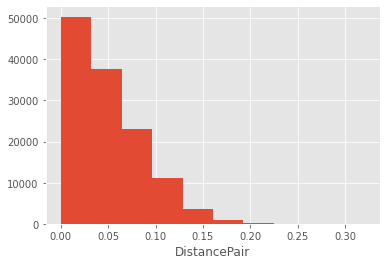

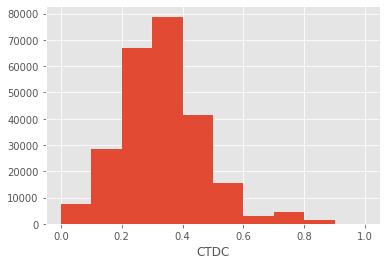

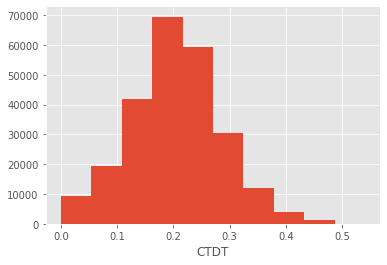

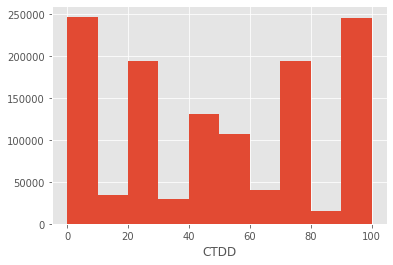

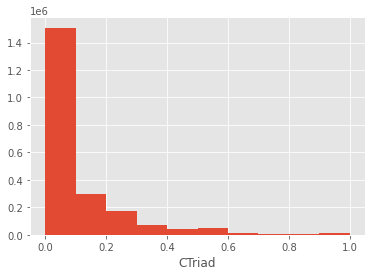

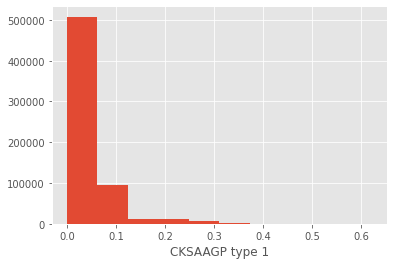

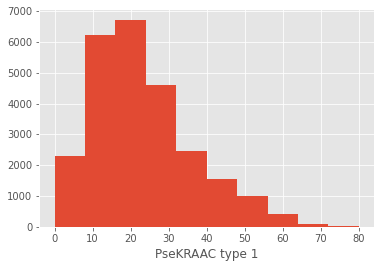

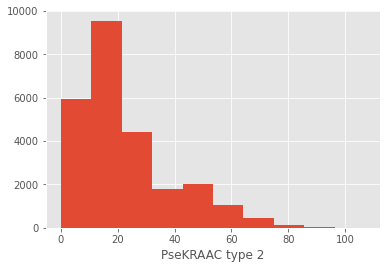

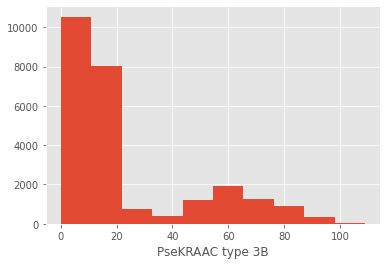

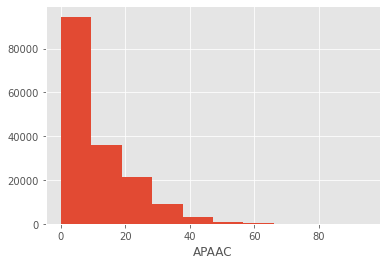

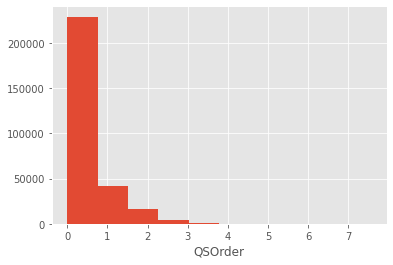

In [25]:
plot_dists(df)

Feature distributions:

Normal: 
Bimodal: GAAC
Uniform: CTDD
Poisson: AAC, DistancePair, CTDC, CTDT, PseKRAAC type 1, PseKRAAC type 2, APAAC, QSOrder
Get rid of it: DPC Type 1, PseKRAAC type 3A, PseKRAAC type 4, PseKRAAC type 5


In [24]:
def get_fasta_from_dataframe(dataframe, output_file: str):
    # adjust this to write function with BioPython
    """
    Function converts sequences and ID's from
    pandas dataframe into .fasta file that can
    be read by iFeatureOmega package.

    Parameters
    ----------
    dataframe : Pandas dataframe

    Returns
    ----------
    Writes .fasta file to current directory.
    """

    with open(output_file, 'w') as f:
        for _, row in dataframe.iterrows():
            f.write(
                '>{}\n{}\n'.format(
                    (row['meso_index']),
                    row['m_protein_seq']))
    return output_file

In [29]:
# def get_fasta_from_dataframe(dataframe, output_file_a:str, output_file_b:str):
#     #adjust this to write function with BioPython
#     #separate functions for each of the input sequences
#     #in training, seq_a = meso and seq_b = thermo
    
    
#     #meso sequence to fasta
#     with open(output_file_a, 'w') as f:
#         for _, row in df.iterrows():
#             f.write('>{}\n{}\n'.format((row['prot_pair_index']), row['m_protein_seq']))
    
#     #thermo sequence to fasta
#     with open(output_file_b, 'w') as f:
#         for _, row in df.iterrows():
#             f.write('>{}\n{}\n'.format((row['prot_pair_index']), (row['t_protein_seq'])))
   
#     #return output files
#     return [output_file_a, output_file_b]

In [13]:
#getting an error in the try/except block


from Bio import Seq, SeqIO

def get_fasta_from_dataframe_biopython(dataframe, output_file:str):
    # Create a list of SeqRecord objects
    records = []
    for _, row in dataframe.iterrows():
        try:
            seq = Seq(row['m_protein_seq'])
        except Exception as e:
            print(f"Skipping row {row.name}: {str(e)}")
            continue
        record = SeqIO.SeqRecord(
            seq=seq,
            id=row['meso_index'],
            description=""
        )
        records.append(record)
    
    # Write the records to a FASTA file
    with open(output_file, 'w') as f:
        SeqIO.write(records, f, 'fasta')
    
    return output_file


In [14]:
def get_protein_descriptors(fasta_file, descriptors=[]):
    
    """
    Generates features from a protein sequence

    Parameters
    ----------
    List of two fasta files with protein sequences.

    Returns
    -------
    Vector of descriptors
    """
    
    #create iProtein object
    protein = iFeatureOmegaCLI.iProtein(fasta_file)
    
    #not sure why we need this yet. Right now it is stored in local directory.
    params = protein.import_parameters('protein_parameters.json')
    
    protein_descriptors = {}
    
    for descriptor in descriptors:
        protein.get_descriptor(descriptor)
        protein_descriptors.update({f'{descriptor}':protein.encodings})
        
    return protein_descriptors

In [15]:
def create_new_dataframe(dataframe, output_file, descriptors=[]):
    """
    Creates new dataframe with descriptors added.

    Parameters
    ----------
    Pandas dataframe, list of descriptors as strings, output file name.

    Returns
    -------
    Dataframe including vector(s) of descriptors
    """

    fasta = get_fasta_from_dataframe(dataframe, output_file)

    feature_dict = get_protein_descriptors(fasta, descriptors)

    df = dataframe.reset_index()

    for desc in descriptors:

        feature_dict[desc].index = feature_dict[desc].index.astype(int)
        features = feature_dict[desc].reset_index()

        df = pd.merge(
            df,
            features,
            how='outer',
            left_index=True,
            right_index=True)

    return df

In [29]:
df = create_new_dataframe(df, 'seq_50k_a.fasta', descriptors=['GAAC'])

File imported successfully.


In [30]:
# def create_new_dataframe(dataframe, output_files, descriptors=[]):
#     """
#     Creates new dataframe with descriptors added.

#     Parameters
#     ----------
#     Pandas dataframe, list of descriptors as strings, output file name.

#     Returns
#     -------
#     Dataframe including vector(s) of descriptors
#     """

#     fasta_files = get_fasta_from_dataframe(dataframe, output_files[0], output_files[1])
    
#     def compute_descriptor_difference(fasta_files, descriptors=[]):
        
#         desc_a = get_protein_descriptors(fasta_files[0], descriptors)
#         desc_b = get_protein_descriptors(fasta_files[1], descriptors)

#         feature_dict = {}

#         for key in desc_a:
#             feature_dict[key] = desc_a[key] - desc_b[key]

#         return feature_dict
    
#     feature_dict = compute_descriptor_difference(fasta_files, descriptors)


#     df = dataframe.reset_index()

#     for desc in descriptors:

#         feature_dict[desc].index = feature_dict[desc].index.astype(int)
#         features = feature_dict[desc].reset_index()

#         df = pd.merge(
#             df,
#             features,
#             how='outer',
#             left_index=True,
#             right_index=True)

#     return df

In [31]:
#this function is only necessary if we get a fasta file with a descriptor generated from component 3

def remove_fasta_description(filename:str):
    
    """
    Removes description from fasta file so that iProtein can read the input.
    Might not be necessary in our current format.
    
    Parameters
    ----------
    Fasta file with protein sequences.

    Returns
    -------
    Fasta file with protein sequences, sans description.
    """
    
    #assign unwanted string to object
    string_to_remove = "<unknown description>"

    #open file
    with open(filename, "r") as file:
        content = file.read()
    
    # Remove the string
    new_content = content.replace(string_to_remove, "")

    #overwrite file without string
    with open(filename, "w") as file:
        seq = file.write(new_content)
        
    return seq

In [32]:
#combine both of the above functions

def fasta_to_descriptors(fasta:str, descriptors=[]):

    #remove description from fasta file
    remove_fasta_description(fasta)
    
    #return protein descriptors
    return get_protein_descriptors(fasta, descriptors=descriptors)

In [33]:
#need to figure out how to pass fasta for both descriptors and append to one dataframe
#set this back to what it was originally. Gonna calculate difference for each descriptors

# def create_new_dataframe(dataframe, fasta_files:list, descriptors=[]):
#     """
#     Creates new dataframe with descriptors added.
    
#     Parameters
#     ----------
#     Pandas dataframe, list of descriptors as strings, output file name.

#     Returns
#     -------
#     Dataframe including vector(s) of descriptors
#     """
    
#     #descriptors for meso sequence
#     fasta = get_fasta_from_dataframe(dataframe, fasta_files[0], fasta_files[1])
    
#     #create feature dictionary for sequence a
#     feature_dict_a = get_protein_descriptors(fasta[0], 'Meso', descriptors)
#     print(feature_dict_a)
    
#     #create feature dictionary for sequence b
#     feature_dict_b = get_protein_descriptors(fasta[1], 'Thermo', descriptors)
    
#     df = dataframe.reset_index()
    
#     #merge meso sequences
#     for desc in descriptors:
        
#         feature_dict_a[desc+'_Meso'].index = feature_dict_a[desc+'_Meso'].index.astype(int)
#         features_a = feature_dict_a[desc+'_Meso'].reset_index()
        
#     df = pd.merge(df, features_a, how='outer', left_index=True, right_index=True)
    
#     #merge thermo sequences
# #     for desc in descriptors:
        
# #         feature_dict_b[desc+'_Thermo'].index = feature_dict_b[desc+'_Thermo'].index.astype(int)
# #         features_b = feature_dict_b[desc+'_Thermo'].reset_index()
        
# #     df = pd.merge(df, features_b, how='outer', left_index=True, right_index=True)
        
#     return df

Let's see how long generating some of the descriptors takes:

In [34]:
df

,index_x,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,...,m_protein_len,t_protein_len,Jaccard_Score,protein_match,index_y,GAAC_alphatic,GAAC_aromatic,GAAC_postivecharge,GAAC_negativecharge,GAAC_uncharge
0,0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,...,206,202,1.0,Yes,12897,0.451456,0.053398,0.165049,0.140777,0.189320
1,1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,...,233,237,1.0,Yes,13026,0.412017,0.064378,0.154506,0.184549,0.184549
2,2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,...,287,252,1.0,Yes,8203,0.543554,0.059233,0.135889,0.097561,0.163763
3,3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,...,234,269,1.0,Yes,3340,0.551282,0.111111,0.094017,0.055556,0.188034
4,4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,...,80,66,1.0,Yes,14020,0.425000,0.200000,0.112500,0.075000,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,6343,6495,0.387574,0.367978,0.360882,336,0.943820,337,0.910811,588,...,370,356,0.5,Yes,15884,0.378378,0.097297,0.127027,0.137838,0.259459
6344,6344,6496,0.488462,0.488462,0.455197,258,0.992308,263,0.882550,619,...,298,260,1.0,Yes,15991,0.426174,0.080537,0.110738,0.167785,0.214765
6345,6345,6497,0.383838,0.376238,0.374384,296,0.976898,299,0.977124,436,...,306,303,1.0,Yes,6443,0.535948,0.052288,0.111111,0.094771,0.205882
6346,6346,6498,0.769231,0.769231,0.769231,78,1.000000,78,1.000000,258,...,78,78,1.0,Yes,5832,0.384615,0.051282,0.269231,0.051282,0.243590


In [35]:
df
df['protein_match'].value_counts()

Yes    5243
No     1105
Name: protein_match, dtype: int64

Try some dimensionality reduction:

In [36]:
#iFeature properties

protein = iFeatureOmegaCLI.iProtein('meso_50k.fasta')
protein.display_feature_types()


        ----- Available feature types ------        
        
        AAC                                                Amino acid composition
        EAAC                                               Enhanced amino acid composition
        CKSAAP type 1                                      Composition of k-spaced amino acid pairs type 1 - normalized
        CKSAAP type 2                                      Composition of k-spaced amino acid pairs type 2 - raw count
        DPC type 1                                         Dipeptide composition type 1 - normalized
        DPC type 2                                         Dipeptide composition type 2 - raw count
        TPC type 1                                         Tripeptide composition type 1 - normalized
        TPC type 2                                         Tripeptide composition type 1 - raw count
        CTDC                                               Composition
        CTDT                                      

In [37]:
"""
this list comes from a combination of reading through the features and determining which might be useful
and timing some of the feature generations. those that took more than 30ish seconds were eliminated
Also removed those that have really high dimensionality (>4000)
"""

feature_list = ['AAC', 'GAAC', 'DistancePair','CTDC', 'CTDT', 'CTDD', 'CTriad',
                'CKSAAGP type 1', 'PseKRAAC type 1', 'PseKRAAC type 2',
                'PseKRAAC type 3B',
                'APAAC', 'QSOrder']

In [38]:
import time

In [39]:
def time_feature_generation(dataframe, file_name:str, descriptor:str):
    
    """
    Times how long it takes to generate a specific descriptor.
    
    Parameters
    ----------
    Pandas dataframe, fasta file name, descriptor name (string).

    Returns
    -------
    Time to generate descriptor.
    """

    # Record the current time
    start_time = time.time()

    # Code to be timed goes here
    create_new_dataframe(dataframe, file_name, descriptors=[descriptor])

    # Record the time again and calculate the elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print the elapsed time
    return elapsed_time

In [40]:
time_feature_generation(df, 'meso_50k.fasta', 'QSOrder')

File imported successfully.


<ipython-input-28-9179a0552258>:25: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(


5.917438983917236

In [41]:
def time_feature_dict(dataframe, file_name:str, feature_list):
    
    """
    Iterates through dictionary of protein descriptors and returns the time it takes to run the code.
    
    Parameters
    ----------
    Pandas dataframe, fasta file name, descriptors (list of strings).

    Returns
    -------
    Dictionary of descriptors and time to generate them.
    """
    
    protein = iFeatureOmegaCLI.iProtein(file_name)
    
    time_dict = {}
    
    for feature in feature_list:
        time_dict[feature] = time_feature_generation(dataframe, file_name, feature)
    
    return time_dict

In [42]:
# time_feature_dict(df, 'meso_50k.fasta', feature_list)

In [43]:
# df = create_new_dataframe(df, 'meso_50k.fasta', descriptors=[feature for feature in feature_list])

In [44]:
df

,index_x,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,...,m_protein_len,t_protein_len,Jaccard_Score,protein_match,index_y,GAAC_alphatic,GAAC_aromatic,GAAC_postivecharge,GAAC_negativecharge,GAAC_uncharge
0,0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,...,206,202,1.0,Yes,12897,0.451456,0.053398,0.165049,0.140777,0.189320
1,1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,...,233,237,1.0,Yes,13026,0.412017,0.064378,0.154506,0.184549,0.184549
2,2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,...,287,252,1.0,Yes,8203,0.543554,0.059233,0.135889,0.097561,0.163763
3,3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,...,234,269,1.0,Yes,3340,0.551282,0.111111,0.094017,0.055556,0.188034
4,4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,...,80,66,1.0,Yes,14020,0.425000,0.200000,0.112500,0.075000,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,6343,6495,0.387574,0.367978,0.360882,336,0.943820,337,0.910811,588,...,370,356,0.5,Yes,15884,0.378378,0.097297,0.127027,0.137838,0.259459
6344,6344,6496,0.488462,0.488462,0.455197,258,0.992308,263,0.882550,619,...,298,260,1.0,Yes,15991,0.426174,0.080537,0.110738,0.167785,0.214765
6345,6345,6497,0.383838,0.376238,0.374384,296,0.976898,299,0.977124,436,...,306,303,1.0,Yes,6443,0.535948,0.052288,0.111111,0.094771,0.205882
6346,6346,6498,0.769231,0.769231,0.769231,78,1.000000,78,1.000000,258,...,78,78,1.0,Yes,5832,0.384615,0.051282,0.269231,0.051282,0.243590


In [45]:
#get rid of stuff that isn't quantitative

df = df.drop(columns = (['Unnamed: 0', 'index_x', 'thermo_index',
                         'm_protein_seq', 't_protein_seq', 'm_protein_desc', 't_protein_desc',
                        'query_align_cov_16s', 'subject_align_cov_16s',
                        'meso_index', 'meso_protein_int_index', 'local_gap_compressed_percent_id_16s', 
                        'scaled_local_query_percent_id_16s', 'scaled_local_symmetric_percent_id_16s',
                       'bit_score_16s', 'm_ogt', 't_ogt', 'taxa_pair_index', 'thermo_protein_int_index'
                       , 'prot_pair_index', 'ogt_difference', 'Jaccard_Score']))

In [46]:
df

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,m_protein_len,t_protein_len,protein_match,index_y,GAAC_alphatic,GAAC_aromatic,GAAC_postivecharge,GAAC_negativecharge,GAAC_uncharge
0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,206,202,Yes,12897,0.451456,0.053398,0.165049,0.140777,0.189320
1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,233,237,Yes,13026,0.412017,0.064378,0.154506,0.184549,0.184549
2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,287,252,Yes,8203,0.543554,0.059233,0.135889,0.097561,0.163763
3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,234,269,Yes,3340,0.551282,0.111111,0.094017,0.055556,0.188034
4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,80,66,Yes,14020,0.425000,0.200000,0.112500,0.075000,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,0.387574,0.367978,0.360882,336,0.943820,337,0.910811,588,370,356,Yes,15884,0.378378,0.097297,0.127027,0.137838,0.259459
6344,0.488462,0.488462,0.455197,258,0.992308,263,0.882550,619,298,260,Yes,15991,0.426174,0.080537,0.110738,0.167785,0.214765
6345,0.383838,0.376238,0.374384,296,0.976898,299,0.977124,436,306,303,Yes,6443,0.535948,0.052288,0.111111,0.094771,0.205882
6346,0.769231,0.769231,0.769231,78,1.000000,78,1.000000,258,78,78,Yes,5832,0.384615,0.051282,0.269231,0.051282,0.243590


Let's do some feature engineering.

In [51]:
AA_comp

array([[0.14563107, 0.02912621],
       [0.06437768, 0.03004292],
       [0.20557491, 0.0174216 ],
       ...,
       [0.15359477, 0.00653595],
       [0.14102564, 0.03846154],
       [0.09561753, 0.00398406]])

In [47]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

train, val = sklearn.model_selection.train_test_split(dev, test_size=0.15, random_state=1)

print(dev.shape)
print(test.shape)
print(train.shape)
print(val.shape)

(5395, 17)
(953, 17)
(4585, 17)
(810, 17)


In [48]:
#ID target and features, separate into separate arrays

target = 'protein_match'
input_features = [columns for columns in df]
input_features.remove(target)

In [49]:
print(input_features)
print(target)

['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len', 'index_y', 'GAAC_alphatic', 'GAAC_aromatic', 'GAAC_postivecharge', 'GAAC_negativecharge', 'GAAC_uncharge']
protein_match


In [50]:
#split X and y

dev_X = dev[input_features].values
test_X = test[input_features].values

dev_y = dev[target].values.reshape(-1,1)
test_y = test[target].values.reshape(-1,1)  

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(5395, 16) (953, 16) (5395, 1) (953, 1)


In [51]:
#same thing for training and validation data

train_X = train[input_features].values
val_X = val[input_features].values

train_y = train[target].values.reshape(-1,1)
val_y = val[target].values.reshape(-1,1) 

Scale the data

In [116]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

Train the model

In [52]:
#Random Forest

model = sklearn.ensemble.RandomForestClassifier(n_estimators=150, max_depth=None, max_samples=0.5,
                                                max_features=0.5, min_weight_fraction_leaf=0.000215,
                                               min_samples_split=10)

model.fit(train_X, train_y.ravel())

RandomForestClassifier(max_features=0.5, max_samples=0.5, min_samples_split=10,
                       min_weight_fraction_leaf=0.000215, n_estimators=150)

Test the model, report relevant statistics

In [53]:
score = model.score(val_X, val_y)
print('Model score is: {}'.format(score))

preds = model.predict(test_X)
print(preds)

Model score is: 0.817283950617284
['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'No'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'No' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes'

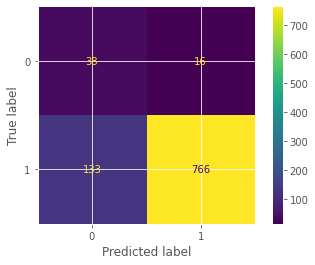

In [54]:
#confusion matrix

confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

Convert the above code into functions.

In [79]:
def train_model(dataframe, columns = [],  target = []):
    """
    Takes dataframe and splits it into a training and testing set. 
    Note: Data is called train and test, but this test set is currently
    closer to a validation set. Keeping nomenclature to keep model robust.
    Trains a KNN classifier model with selected data.
    
    Params
    ----------
    dataframe: Pandas dataframe 
    columns: list of strings, representing input features
    target: list of strings, representing target feature(s)

    Returns
    -------
    -Sk-learn model object
    -train data (features)
    -train data (target)
    -validation data (features)
    -validation data (target)
    """
    #split data
    dev, test = sklearn.model_selection.train_test_split(dataframe, test_size=0.15, random_state=1)
    
    #test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(dev))
    assert "pandas.core.frame.DataFrame" in str(type(test))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))
   
    #split into input and output feature(s)
    dev_X = dev[columns].values
    test_X = test[columns].values

    dev_y = dev[target].values.reshape(-1,1)
    test_y = test[target].values.reshape(-1,1)
    
    #scale data
    scaler = sklearn.preprocessing.StandardScaler()
    dev_X = scaler.fit_transform(dev_X)
    test_X = scaler.fit_transform(test_X)
    
    #train model
    model = sklearn.ensemble.RandomForestClassifier()
    model = model.fit(dev_X, dev_y.ravel())
    
    return model, dev_X, dev_y, test_X, test_y
    

In [80]:
model, dev_X, dev_y, test_X, test_y = train_model(df, columns = input_features, 
                                          target='protein_match')

In [81]:
class TestModelTraining(unittest.TestCase):
    
    def test_invalid_inputs(self):
    
        #test that input data type is correct
        
        try:
            train_model([1,2,3], columns = 'string', target = 'string')
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)
    
#     def test_input_distro(self):
        
#         #test that dev and test features have similar Jensen Shannon Distribution
        
#         JSD = (
#             scipy.stats.bootstrap((train_reg(split_data(df)[0], split_data(df)[1],
#                                 columns = input_features, target=target)[1], train_reg(split_data(df)[0], 
#                                 split_data(df)[1], columns = input_features, target=target)[3]), 
#                                   JSD_dev_and_test, n_resamples=1000, 
#                                   batch=5, method='percentile')
#         )

#         div = JSD.confidence_interval[1]
        
#         #asserts that the divergence between data sets is sufficiently low
#         assert abs(div) < 0.3, "Warning! High JSD between dev and test set!"
        
    def test_output_format(self):
        
        #asserts that function returns 4 objects to be assigned to pearson_corr, model, test_X, test_y
        assert len(train_model(df, columns = input_features, 
                                          target = target)) == 5
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelTraining)
_ = unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 14.866s

OK


In [46]:
#need to fix this

def evaluate_model(model, test_X, test_y):
    
    """
    Takes a trained model and test data and tests the model.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    Vector of predictions based on the model (numpy array)
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    preds = model.predict(test_X)
    
    return preds

In [47]:
preds = evaluate_model(model, test_X, test_y)
preds

array([False, False, False, ..., False,  True, False])

In [48]:
class TestModelPerformance(unittest.TestCase):

    def test_asserts(self):
        model, _, _, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert that input types are correct
        with self.assertRaises(AssertionError):
            evaluate_model(model, [1, 2, 3], test_y)
            
    def test_model_output(self):
        model, _, _, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_pred_dimension(self):
        model, _, _, test_X, test_y = train_model(df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelPerformance)
_ = unittest.TextTestRunner().run(suite)


...
----------------------------------------------------------------------
Ran 3 tests in 236.519s

OK


A good test here can be adding outliers and seeing how much the score and predictions change (probably for the above function).

In [49]:
def plot_model(model, test_X, test_y):
    """
    Takes a test KNN Classifier model and plots the confusion matrix.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Confusion predictions vs. observations
    -Model score
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    score = model.score(test_X, test_y)
    preds = evaluate_model(model, test_X, test_y)
   
    # plot confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
    cm_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
    
    cm_plot.plot(cmap=plt.cm.Blues)
    cm_plot.ax_.set_title('Confusion Matrix')
    
    return score
    

In [50]:
#make some appropriate display labels here

plot_model(model, test_X, test_y)

0.9904

In [51]:
#wrapper function

def RF_wrapper(dataframe):
    """
    Takes dataframe and runs it through kNN model.
    
    Params
    ----------
    dataframe: Pandas dataframe 

    Returns
    -------
    -Target feature predictions
    -Parity plot
    """
    
    assert 'pandas.core.frame.DataFrame' in str(type(dataframe))

    #user inputs target feature
    target = 'protein_match'
    
    #define input features
    input_features = [columns for columns in dataframe]
    
    input_features.remove(target)

    #train the model based off data split
    model, dev_X, dev_y, test_X, test_y = train_model(
                                        dataframe, columns=input_features, 
                                        target=target
                                                   )
    
    #test the model and return predictions
    preds = evaluate_model(model, test_X, test_y)

    #plot the results of the model
    plot_model(model, test_X, test_y)
    
    return preds

In [52]:
RF_wrapper(df)

array([False, False, False, ..., False,  True, False])

In [53]:
class TestWrapper(unittest.TestCase):
    
    def test_wrapper_input(self):
        #test that input data type is correct
        try:
            RF_wrapper([1,2,3])
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)

    def test_wrapper_output(self):
        model, _, _, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_output_dimension(self):
        model, _, _, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestWrapper)
_ = unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 158.947s

OK


**IGNORE BELOW**

In [54]:
# #plot empirical distribution of scaled_local_query_percent_id

# target = df['protein_match']
# #create histplot
# fig, ax = plt.subplots()

# sns.histplot(data = df, x = target)

# ax.set_title('Sample Histogram', fontsize=16)
# ax.set_xlabel('Class', fontsize=14)
# ax.set_ylabel('Count', fontsize=14)

Things I've tried to improve model: 

1. drop bit scores over 1000
2. Switch to 85/15 train/test split
3. Lasso regression - not great
4. Ridge regression - R2 = 0.87, about the same as normal Linear regression
5. KNN regression (n_neighbors optimized at 8) gives best result, R2 = ~0.93 --> 
*got it up to .942 by removing a few features
6. Decision tree regressor was slightly worse than KNN
7. Input DT classifier and RF classifier. RF classifier has best performance
8. Changed target to binary protein function match